# How does one overlay remotely sensed pixels onto a low angle ground photo?

### It's not easy but it is doable.

###### See the notebook "Overlay Data preprocessing.ipynb" for the details of how to create these data

In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data, img_as_float

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
import skimage.transform as trans

import shutil
import itertools
from datetime import datetime

import rasterio

In [2]:
import sys
sys.path.append(r"..\..")

import pyphenocam

### Outside of this notebook we extracted a chunk of landsat to use as a managable reference grid

In [3]:
base_dname = r"J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge"

landsat_subset_fname = os.path.join(base_dname, "Landsat", "Subset", "landsat_subset.tif")
landsat = rasterio.open(landsat_subset_fname)
landsat_data = landsat.read()

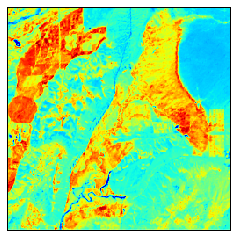

In [4]:
%matplotlib inline
plt.imshow(landsat_data[0,:,:], interpolation='none')
pyphenocam.plotting.format_photo_axes(plt.gca())

## This was overlaid on our ArcScene photo recreation and converted to a couple of grid representations

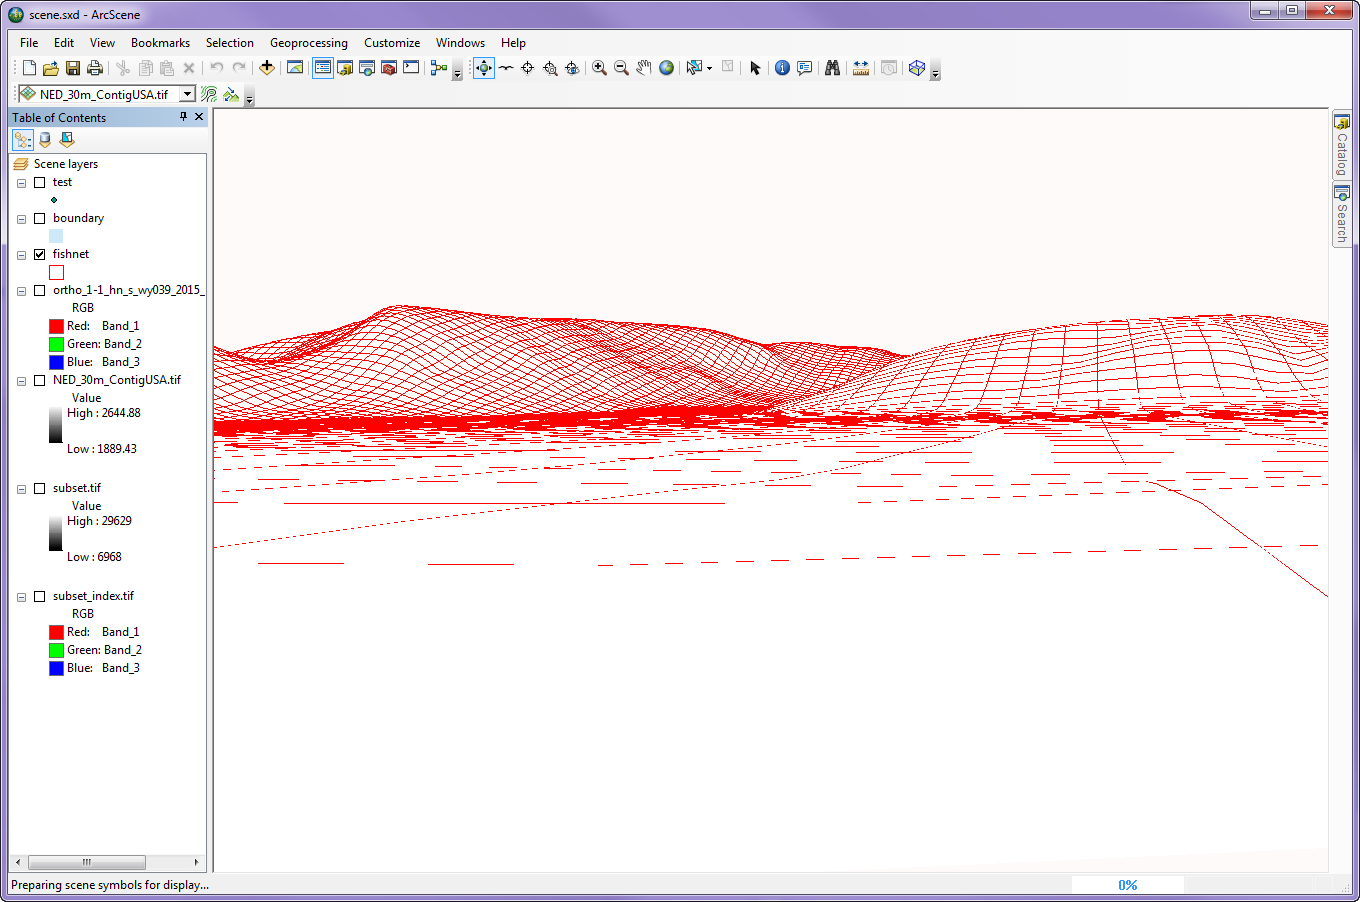

In [5]:
from IPython.display import Image
Image(filename=r"J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge\ArcScene\ScreneGrab.png")

### Which are then exported as flat images for use in the rest of this notebook

In [6]:
landsat_fishnet_fname = os.path.join(base_dname, "ArcScene", "landsat_fishnet.bmp")
landsat_index_fname = os.path.join(base_dname, "ArcScene", "landsat_subset_index.bmp")

phenosite = pyphenocam.dataaccess.get_site('nationalelkrefuge')
which_img = -197


Extracted exposure:  9


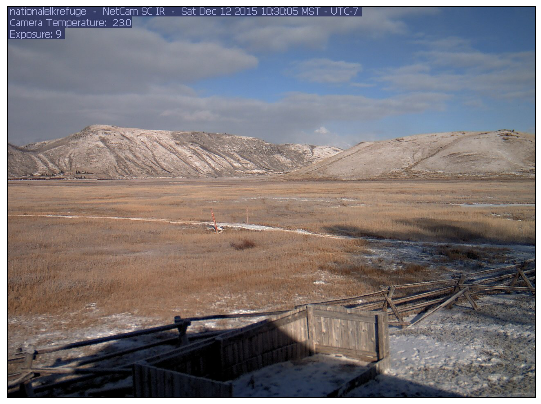

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
local_fname = os.path.join(base_dname, "ArcScene", "InputData", "nationalelkrefuge_2015_12_12_103005.jpg")
# print local_fname
# sample_image = phenosite.get_local_image(phenosite.midday_fnames[which_img])
sample_photo_fname = phenosite.get_closest_fname(datetime(2015, 12, 12, 10, 30))
sample_image = local_photo_fname = phenosite.get_local_image(sample_photo_fname)
ax.imshow(sample_image)

# pyphenocam.plotting.add_rois(ax, phenosite, vistype='line', lw=7, alpha=0.9)
# 
pyphenocam.plotting.format_photo_axes(ax)
# plt.legend(loc=1)

exposure = pyphenocam.headerextraction.get_exposure(local_fname)
print "Extracted exposure: ", exposure

### Our landsat grid image create in ArcScene

In [8]:
data_grid = skimage.io.imread(landsat_fishnet_fname)


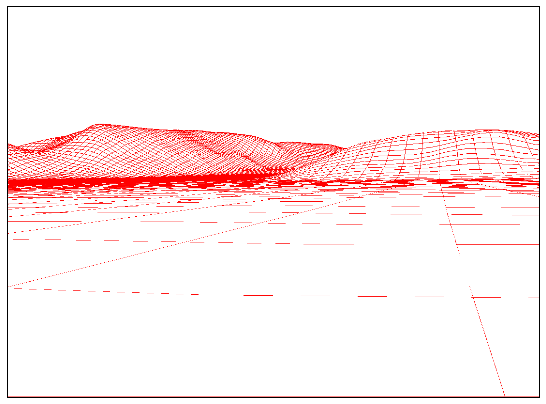

In [9]:
plt.figure(figsize=(10, 7))
plt.imshow(data_grid)
pyphenocam.plotting.format_photo_axes(plt.gca())

### But how do these align?

In [10]:
# While approximatly equal in aspect we need to reshape our grid overlay
#to match the dimensions of our photos
data_trans = trans.resize(data_grid, 
            (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=False)

In [11]:
# And we need to 'burn' the red lines above into our sample image for display
superimposed = sample_image.copy()
superimposed[data_trans[:,:,1]<.98, 0] = superimposed.max()
superimposed[data_trans[:,:,1]<.98, 1] = superimposed[data_trans[:,:,1]<.98, 1]
superimposed[data_trans[:,:,1]<.98, 2] = superimposed[data_trans[:,:,1]<.98, 1]



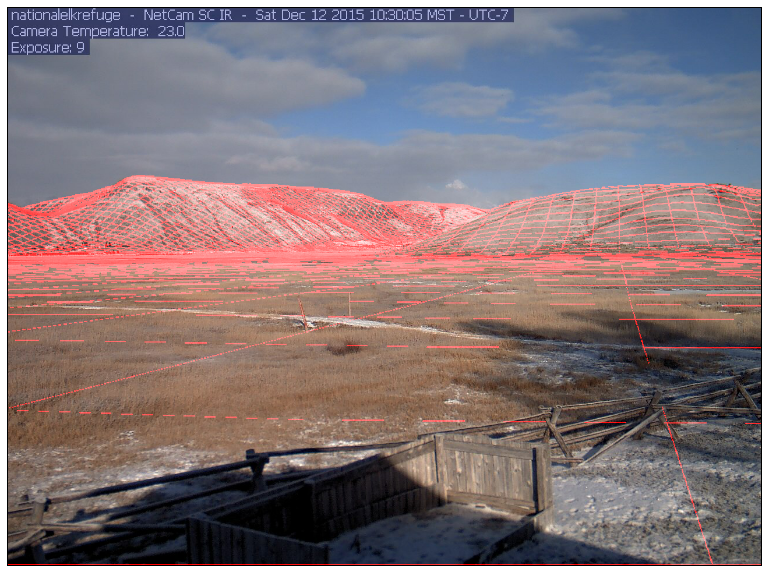

In [12]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
# local_fname = phenosite.get_local_image_fname(phenosite.midday_fnames[which_img])
# print local_fname
ax.imshow(superimposed)
pyphenocam.plotting.format_photo_axes(ax)



## Now to crosswalk this to specific Landsat pixels

In [13]:
index_grid = skimage.io.imread(landsat_index_fname)
index_grid = trans.resize(index_grid, (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=True, order=0)

index_grid = np.ma.masked_where(index_grid > 254, index_grid)

##### This grid was construncted such that the red channel contains an index to the landsat pixel row and the green channel contains an indexto the landsat pixel column

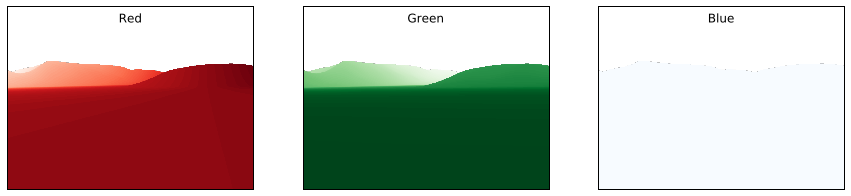

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for index, cmap in enumerate([mpl.cm.Reds, mpl.cm.Greens, mpl.cm.Blues]):
    axes[index].imshow(index_grid[:,:,index], cmap=cmap)
    pyphenocam.plotting.format_photo_axes(axes[index])
    pyphenocam.plotting.add_inner_title(axes[index], cmap.name[:-1], 9)

    
#Note that the blue channel is not used

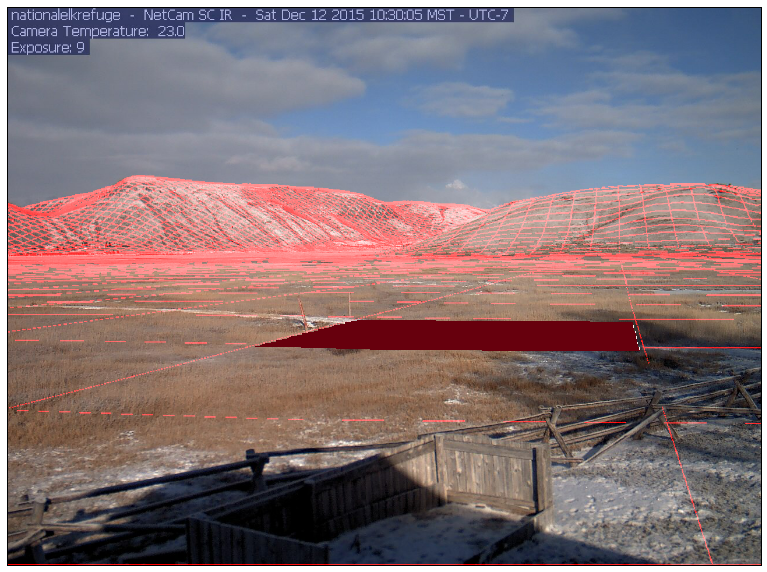

In [15]:
single_pixel = np.logical_and(index_grid[:,:,0]==127, index_grid[:,:,1]==242)

single_pixel = np.ma.asarray(trans.resize(single_pixel, 
            (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

single_pixel.mask = single_pixel==False

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(superimposed)
ax.imshow(single_pixel, alpha = 1.0, cmap=mpl.cm.Reds, interpolation='none')
pyphenocam.plotting.format_photo_axes(ax)

# But how do we get the actual coordinates of the pixel centroids instead of this rather arbitrary index?

In [16]:
x = 1
y = 1

landsat.affine *  (x, y)

(517395.0, 4822455.0)

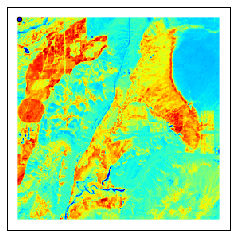

In [17]:
plt.imshow(landsat_data[0,:,:], interpolation='none')
pyphenocam.plotting.format_photo_axes(plt.gca())
plt.scatter(*(x, y))

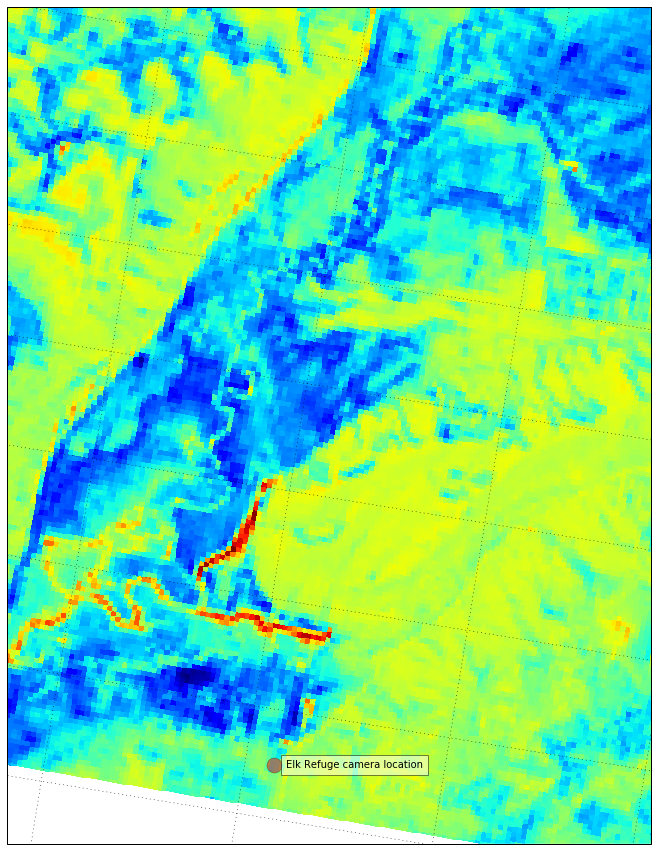

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax_proj = ccrs.LambertConformal()
landsat_proj = ccrs.UTM(zone=12, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
geodetic = ccrs.Geodetic()

fig = plt.figure(figsize=(15, 15))
ax_extent = [phenosite.x - 0.02, phenosite.x + 0.02, phenosite.y - 0.002, phenosite.y + 0.040]

landsat_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

ax = plt.axes(projection=ax_proj)
ax.set_extent(ax_extent, ccrs.Geodetic())
ax.imshow(landsat_data[0, :, :], origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet_r)

# # ax.set_xmargin(0.05)
# # ax.set_ymargin(0.10)

# mark a known place to help us geo-locate ourselves
locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
ax.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
ax.text(locx+75, locy-15, 'Elk Refuge camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS)
ax.gridlines()
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')


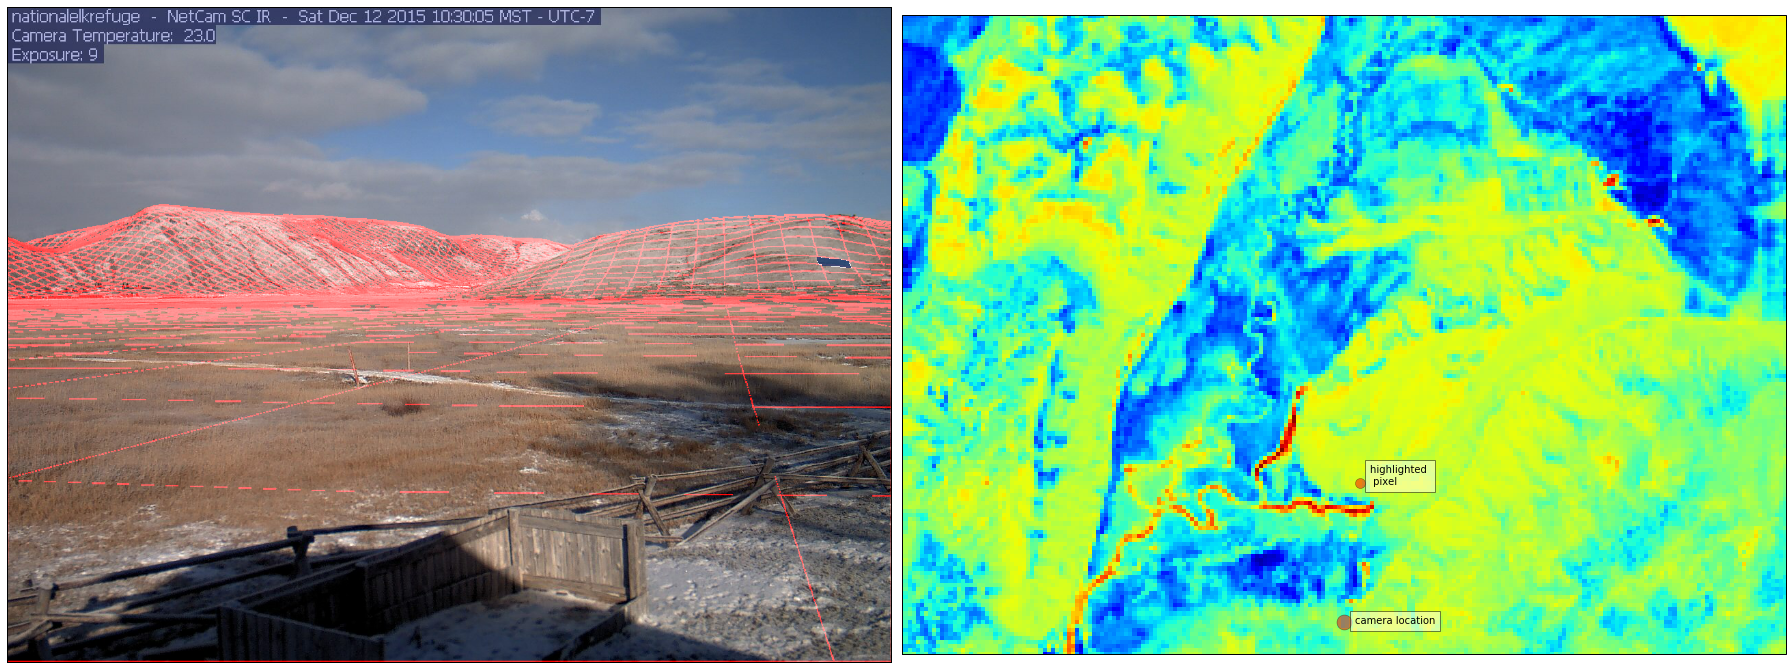

In [22]:
%matplotlib inline
from ipywidgets import interactive

col_index, row_index = 0,0
#col_index=127, row_index=250
def plot_one(col_index=127, row_index=242):
    single_pixel = np.logical_and(index_grid[:,:,0]==col_index, index_grid[:,:,1]==row_index)

    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

    single_pixel.mask = single_pixel==False

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot(121)
    ax.imshow(superimposed)
    ax.imshow(single_pixel, alpha = 0.75, cmap=mpl.cm.Blues, interpolation='none')
    pyphenocam.plotting.format_photo_axes(ax)

    ax_proj = landsat_proj
    ax2 = plt.subplot(122, projection=ax_proj)
    ax_extent = [phenosite.x - 0.04, phenosite.x + 0.04, phenosite.y - 0.002, phenosite.y + 0.040]
    ax2.set_extent(ax_extent, ccrs.Geodetic())
    ax2.imshow(landsat_data[0, :, :], origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet_r)
    colx, coly = landsat.affine * (col_index, row_index)
    colx += landsat.transform[1]/2.
    coly += landsat.transform[5]/2.
    
    colxgeo, colygeo = list(ax_proj.transform_point(colx, coly, landsat_proj))
    ax2.plot(colxgeo, colygeo, 'bo', markersize=10, color='red', alpha=0.5)
    ax2.text(colxgeo+75, colygeo-15, 'highlighted \n pixel', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    # mark a known place to help us geo-locate ourselves
    locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
    ax2.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
    ax2.text(locx+75, locy-10, 'camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    plt.tight_layout()
    
interactive(plot_one, col_index=(0, landsat.shape[0], 1), row_index=(0, landsat.shape[1], 1))

# And of course we can do this same process with MODIS data

In [25]:
modis_fishnet_fname = os.path.join(base_dname, "ArcScene", "modis_fishnet.bmp")
modis_index_fname = os.path.join(base_dname, "ArcScene", "modis_subset_index.bmp")

In [26]:
modis_data_grid = skimage.io.imread(modis_fishnet_fname)


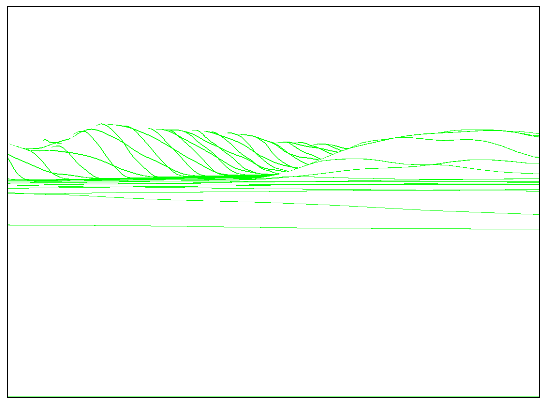

In [27]:
plt.figure(figsize=(10, 7))
plt.imshow(modis_data_grid)
pyphenocam.plotting.format_photo_axes(plt.gca())

### But how do these align?

In [28]:
# While approximatly equal in aspect we need to reshape our grid overlay
#to match the dimensions of our photos
modis_data_trans = trans.resize(modis_data_grid, 
            (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=False)

In [29]:
modis_data_trans.shape

(960L, 1296L, 3L)

In [30]:
# And we need to 'burn' the red lines above into our sample image for display
# superimposed = sample_image.copy()
superimposed[modis_data_trans[:,:,2]<.98, 0] = superimposed[modis_data_trans[:,:,2]<.98, 2]
superimposed[modis_data_trans[:,:,2]<.98, 1] = superimposed.max()
superimposed[modis_data_trans[:,:,2]<.98, 2] = superimposed[modis_data_trans[:,:,2]<.98, 2]



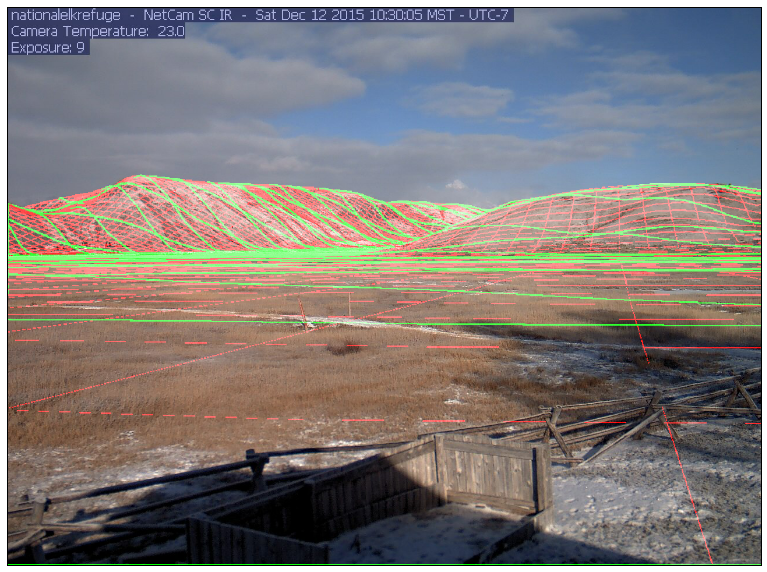

In [31]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
# local_fname = phenosite.get_local_image_fname(phenosite.midday_fnames[which_img])
# print local_fname
ax.imshow(superimposed)
pyphenocam.plotting.format_photo_axes(ax)

